This Notebook contains an ECG classification approach using Convolutional Neural Network.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
input_dir = "/content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/training_set_splitted/train"

In [3]:
import os

# list the data present in the dataset
dirs = sorted(os.listdir(input_dir))
print(dirs)

['S001_128.mat', 'S001_128_ann.mat', 'S001_128_rpk.mat', 'S002_128.mat', 'S002_128_ann.mat', 'S002_128_rpk.mat', 'S003_128.mat', 'S003_128_ann.mat', 'S003_128_rpk.mat', 'S004_128.mat', 'S004_128_ann.mat', 'S004_128_rpk.mat', 'S005_128.mat', 'S005_128_ann.mat', 'S005_128_rpk.mat', 'S006_128.mat', 'S006_128_ann.mat', 'S006_128_rpk.mat', 'S007_128.mat', 'S007_128_ann.mat', 'S007_128_rpk.mat', 'S008_128.mat', 'S008_128_ann.mat', 'S008_128_rpk.mat', 'S009_128.mat', 'S009_128_ann.mat', 'S009_128_rpk.mat', 'S010_128.mat', 'S010_128_ann.mat', 'S010_128_rpk.mat', 'S011_128.mat', 'S011_128_ann.mat', 'S011_128_rpk.mat', 'S012_128.mat', 'S012_128_ann.mat', 'S012_128_rpk.mat', 'S013_128.mat', 'S013_128_ann.mat', 'S013_128_rpk.mat', 'S014_128.mat', 'S014_128_ann.mat', 'S014_128_rpk.mat', 'S015_128.mat', 'S015_128_ann.mat', 'S015_128_rpk.mat', 'S016_128.mat', 'S016_128_ann.mat', 'S016_128_rpk.mat', 'S017_128.mat', 'S017_128_ann.mat', 'S017_128_rpk.mat', 'S018_128.mat', 'S018_128_ann.mat', 'S018_128_r

In [4]:
# environment setup
from scipy.io import loadmat
import numpy as np, os, sys, joblib
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import pandas as pd
import random

#Setting random seed for reproducibility
#Remember to use always SEED for the functions that requires it (like Scikit models)
SEED = 1234
np.random.seed(SEED)
pd.core.common._random_stat = SEED
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:
# Utility function to load data

def load_data(ecg_file):
  ecg = loadmat(ecg_file)
  rpk_file = ecg_file.replace('.mat', '_rpk.mat')
  rpk = loadmat(rpk_file)
  ann_file = ecg_file.replace('.mat', '_ann.mat')
  ann = loadmat(ann_file)
  return ecg, rpk, ann

In [6]:
# Get the ecg file for each sample and create a list of all ecgs
ecg_files = []

for f in dirs:
  g = input_dir+'/'+f
  if g.find('_ann') == -1 and g.find('_rpk') == -1:
   ecg_files.append(g)

num_files = len(ecg_files)
# Create lists that will contains each data types (ecg, labels, rpeaks) an filenames (a list which contains the original filename for each sample)
filenames = list()
ecgs = list()
rpks = list()
anns = list()

for i in range(num_files):
  ecg, rpk, ann = load_data(ecg_files[i])
  print(
        "\rLoading file: {}/{}"
            .format(i+1, num_files),
        end=""
    )
  ecgs.append(ecg)
  rpks.append(rpk)
  anns.append(ann)
  filenames.append(ecg_files[i])

#ecg = np.asarray(loadmat(g)['ecg'], dtype=np.float64)
#rpk = np.asarray(loadmat(input_dir + "/S083_250_rpk.mat")['rpeaks'], dtype=np.float64)
#ann = np.asarray(loadmat(input_dir + "/S083_250_ann.mat")['labels'])

Loading file: 90/90

In [7]:
! pip install neurokit2 tdqm

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=95091171f95d4aba64426e1c8af2a0002eaf4829501204d6f08c5b98f3c8bdf7
  Stored in directory: /root/.cache/pip/wheels/c6/f0/d9/9fa5ff78c0f9d5a0a427bbbb4893c283520ddfccb885ea2205
Successfully built tdqm


In [8]:
import neurokit2 as nk

In [9]:
# Utility: given the filename of a signal it returns the sampling frequency
def ecg_freq(filename):
  if '128' in filename:
    return 128
  else:
    return 250

In [10]:
# Try to extract each single heartbeat

# list of list that contains all heartbeats divided by patient
patient_heartbeats = []

for i in tqdm(range(len(ecgs))):
  # extract a sample ecgd
  ecg_sample = np.asarray(ecgs[i]['ecg'], dtype=np.float64)
  sampling = ecg_freq(filenames[i])
  #ecg_sample_= np.arange(0, ecg_sample.shape[0]/sampling, 1/sampling)
  # clean ecg_sample
  ecg_signal_l1 = nk.ecg_clean(ecg_sample[:,0], sampling_rate=sampling, method='neurokit2')
  
  #Extract peaks from traning set and their labels
  sample_rpeaks = rpks[i]['rpeaks'] 
  # Handling last beats (if last rpeak is >= to current ecg lenght, we remove it)
  add_padding=False
  if sample_rpeaks[-1] >= len(ecg_signal_l1):
    #sample_labels = sample_labels[:-1]
    sample_rpeaks = sample_rpeaks[:-1] 
    add_padding = True
  rpeaks = {'ECG_R_Peaks': sample_rpeaks.flatten(), 'sampling_rate': sampling}

  # extract heartbeats of current ecg
  ecg_heartbeats_l1 = nk.ecg_segment(ecg_cleaned=ecg_signal_l1, rpeaks=rpeaks['ECG_R_Peaks'], sampling_rate=sampling)

  if(add_padding == True): #If we cannot extract the last beat, we replicate the last good beat
   ecg_heartbeats_l1[str(int(list(ecg_heartbeats_l1.keys())[-1]) + 1)] = ecg_heartbeats_l1[list(ecg_heartbeats_l1.keys())[-1]]

  patient_heartbeats.append(ecg_heartbeats_l1)

100%|██████████| 90/90 [13:24<00:00,  8.94s/it]


In [11]:
#load the heartbeats inside an array
heartbeats = []

for p in range(len(patient_heartbeats)):
 for b in patient_heartbeats[p].keys():
  heartbeats.append(list(patient_heartbeats[p][b].Signal))

In [12]:
#removing nan values and substituting them with 0s
for i in range(len(heartbeats)):
    for j in range(len(heartbeats[i])):
        if(str(heartbeats[i][j]) == 'nan'):
            heartbeats[i][j] = 0

In [13]:
classes_name = ['N', 'S', 'V']

In [14]:
# list which contains all labels of each beat
all_labels = []

for sample in anns:
  for beat in sample['labels']:
    all_labels.append(beat)

In [15]:
print(len(all_labels))
print(len(heartbeats))

213024
213024


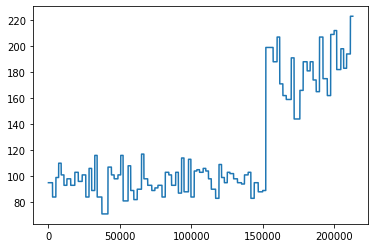

In [16]:
lengths = []
for b in heartbeats:
   lengths.append(len(b))

import matplotlib.pyplot as plt

plt.plot(lengths)

max_len = max(lengths)

In [17]:
import tensorflow as tf
#pad heartbeats in order to have the same dimension
heartbeats = tf.keras.preprocessing.sequence.pad_sequences(heartbeats, maxlen=max_len, dtype='float32', truncating='post',padding="post")

In [ ]:
#features = dict(patient_heartbeats = heartbeats, target = all_labels)

In [ ]:
#features_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in features.items() ]))

In [18]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_labels)

#One hot encoding of the target values
ohe = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
target_ohe = ohe.fit_transform(integer_encoded)

In [19]:
label_encoder.inverse_transform([0,1,2])

array(['N', 'S', 'V'], dtype='<U1')

In [20]:
ohe.inverse_transform([[1, 0, 0], [0,1,0], [0,0,1]])

array([[0],
       [1],
       [2]])

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(heartbeats, target_ohe, test_size=0.2, random_state=SEED,
                               shuffle=True, stratify=target_ohe)

In [ ]:
!pip install imbalanced-learn

In [ ]:
# RESAMPLING TO DEAL THE HEAVY CLASS IMBALANCE (it does not work for now)

# Perform resampling over the dataset to balance classes
# example of random undersampling to balance the class distribution
#from collections import Counter
#from sklearn.datasets import make_classification
#from imblearn.under_sampling import RandomUnderSampler

#y_integers = np.argmax(y_train, axis=1)
# summarize class distribution
#print(Counter(np.ravel(y_integers)))
# define undersample strategy
#undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform (applied 2 times to balance all classes)
#X_train, y_train = undersample.fit_resample(X_train, y_train)
##X_train, y_train = undersample.fit_resample(X_train, y_train)
#train_features, train_target = undersample.fit_resample(train_features, train_target)
# summarize class distribution
#y_integers = np.argmax(y_train, axis=1)
#print(Counter(np.ravel(y_integers)))

Counter({0: 156815, 1: 7454, 2: 6150})
Counter({0: 6150, 1: 6150, 2: 6150})


In [22]:
X_train = X_train.reshape(-1, max_len, 1)

X_val = X_val.reshape(-1, max_len, 1)


In [23]:
X_train.shape

(170419, 223, 1)

In [24]:
len(y_train)

170419

In [25]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(128)

In [26]:
# Considering class imbalance: class weightning to reduce the bias in the dataset

from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
                                      class_weight = "balanced",
                                      classes = np.unique(y_integers),
                                      y = y_integers                                             
                                    )

class_weights = dict(zip(np.unique(y_integers), class_weights))
class_weights

{0: 0.3622506350370394, 1: 7.620919416867901, 2: 9.236802168021681}

In [27]:
X_train.shape, y_train.shape

((170419, 223, 1), (170419, 3))

Now Let's define the model, a simple CNN with 1D convolution layers

In [ ]:
import tensorflow as tf

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='same',
                        activation=tf.nn.leaky_relu, input_shape=[max_len, 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        padding='same', activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [ ]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 223, 16)           64        
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 111, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 111, 64)           3136      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 55, 64)           0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                      

In [ ]:
learning_rate = 0.001
cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [ ]:
history = cnn_model.fit(train_data, 
    validation_data=validation_data,
    shuffle= True,
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
10652/10652 [==============================] - 109s 10ms/step - loss: 0.6286 - accuracy: 0.7101 - precision_5: 0.7351 - recall_5: 0.6549 - val_loss: 0.6028 - val_accuracy: 0.7439 - val_precision_5: 0.7739 - val_recall_5: 0.6857
Epoch 2/15
10652/10652 [==============================] - 96s 9ms/step - loss: 0.5162 - accuracy: 0.7746 - precision_5: 0.7911 - recall_5: 0.7487 - val_loss: 0.5210 - val_accuracy: 0.8024 - val_precision_5: 0.8276 - val_recall_5: 0.7596
Epoch 3/15
10652/10652 [==============================] - 99s 9ms/step - loss: 0.4731 - accuracy: 0.7951 - precision_5: 0.8089 - recall_5: 0.7748 - val_loss: 0.4755 - val_accuracy: 0.8020 - val_precision_5: 0.8197 - val_recall_5: 0.7723
Epoch 4/15
10652/10652 [==============================] - 96s 9ms/step - loss: 0.4474 - accuracy: 0.8060 - precision_5: 0.8184 - recall_5: 0.7885 - val_loss: 0.4249 - val_accuracy: 0.8356 - val_precision_5: 0.8514 - val_recall_5: 0.8109
Epoch 5/15
10652/10652 [==========================

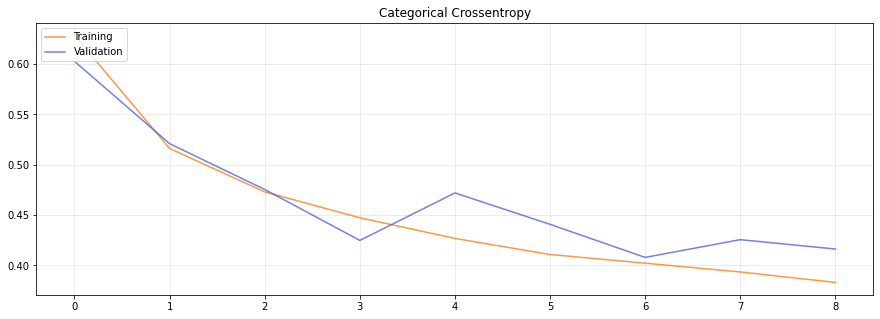

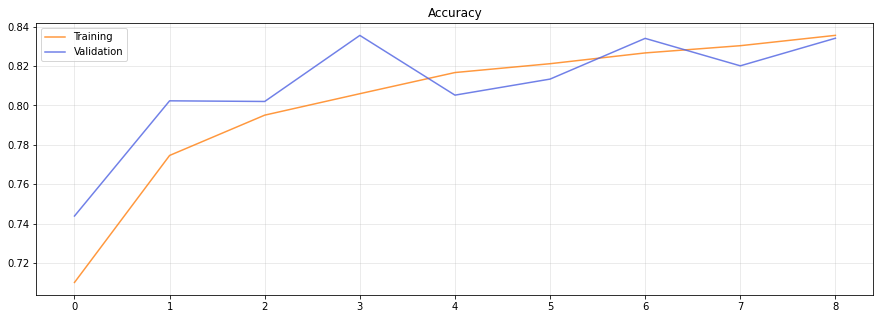

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data.as_numpy_iterator():
    predictions.append(cnn_model.predict(element[0]))

In [ ]:
predictions_f = [item for sublist in predictions for item in sublist]

In [ ]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [ ]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)    

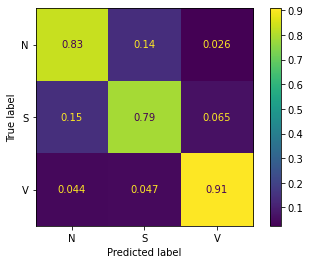

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

#cm = confusion_matrix(y, y_pred, labels=['N', 'S', 'V'])
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                #display_labels=['N', 'S', 'V'])
#disp.plot()
#plt.show()
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [ ]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       0.99      0.83      0.91     39204
           S       0.21      0.79      0.33      1864
           V       0.55      0.91      0.69      1537

    accuracy                           0.84     42605
   macro avg       0.58      0.84      0.64     42605
weighted avg       0.94      0.84      0.87     42605



# VGG 1D

In [32]:
vgg = tf.keras.Sequential()

vgg.add(tf.keras.layers.Conv1D(input_shape=[max_len, 1],filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(tf.keras.layers.MaxPooling1D(pool_size=2,strides=2))
vgg.add(tf.keras.layers.GlobalMaxPooling1D())
vgg.add(tf.keras.layers.Dense(512, activation='relu'))
vgg.add(tf.keras.layers.Dropout(0.4))
vgg.add(tf.keras.layers.Dense(3,activation='softmax'))


learning_rate = 0.001
vgg.compile(
    optimizer = tf.keras.optimizers.Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
)

In [33]:
vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 223, 64)           256       
                                                                 
 conv1d_14 (Conv1D)          (None, 223, 64)           12352     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 111, 64)          0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 111, 128)          24704     
                                                                 
 conv1d_16 (Conv1D)          (None, 111, 128)          49280     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 55, 128)          0         
 1D)                                                  

In [34]:
class_weights

{0: 0.3622506350370394, 1: 7.620919416867901, 2: 9.236802168021681}

In [35]:
history = vgg.fit(train_data, 
    validation_data=validation_data,
    shuffle= True,
    epochs = 15,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),
    class_weight = class_weights
).history

Epoch 1/15
1332/1332 [==============================] - 141s 104ms/step - loss: 0.5395 - accuracy: 0.7562 - precision_1: 0.8026 - recall_1: 0.6591 - val_loss: 0.3026 - val_accuracy: 0.8937 - val_precision_1: 0.9091 - val_recall_1: 0.8774
Epoch 2/15
1332/1332 [==============================] - 138s 104ms/step - loss: 0.2713 - accuracy: 0.8938 - precision_1: 0.9006 - recall_1: 0.8870 - val_loss: 0.2324 - val_accuracy: 0.9121 - val_precision_1: 0.9185 - val_recall_1: 0.9063
Epoch 3/15
1332/1332 [==============================] - 139s 104ms/step - loss: 0.2147 - accuracy: 0.9168 - precision_1: 0.9208 - recall_1: 0.9130 - val_loss: 0.2638 - val_accuracy: 0.8958 - val_precision_1: 0.9027 - val_recall_1: 0.8896
Epoch 4/15
1332/1332 [==============================] - 140s 105ms/step - loss: 0.1830 - accuracy: 0.9258 - precision_1: 0.9290 - recall_1: 0.9231 - val_loss: 0.1810 - val_accuracy: 0.9292 - val_precision_1: 0.9342 - val_recall_1: 0.9258
Epoch 5/15
1332/1332 [==========================

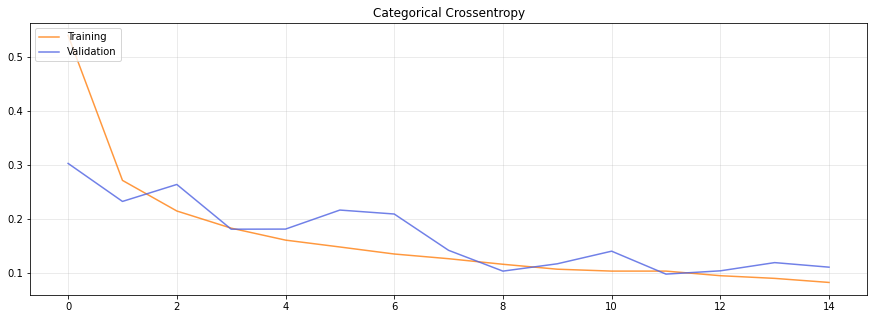

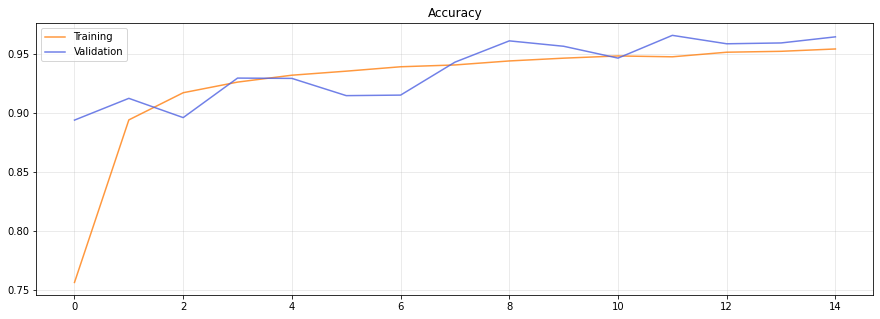

In [36]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [37]:
#Computing the prediction of the model on the validation set
predictions = []
for element in validation_data.as_numpy_iterator():
    predictions.append(vgg.predict(element[0]))

In [38]:
predictions_f = [item for sublist in predictions for item in sublist]

In [39]:
predictions_oh = []
#transform prediction into one-hot-encoding 
for i in range(len(predictions_f)):
    predictions_oh.append(tf.one_hot(tf.argmax(predictions_f[i]), depth=3))

In [40]:
#Compute the true and prediction array in order to plot the confusion matrix
y = []

for y_t in y_val.tolist():
    if(y_t == [1, 0, 0]):
        y.append('N')
    if(y_t == [0, 1 ,0]):
        y.append('S')
    if(y_t == [0, 0 ,1]):
        y.append('V')    

y_pred = []

for y_t in predictions_oh:
    if(all(tf.equal(y_t, tf.constant([1, 0, 0], dtype=np.float32)))):
        y_pred.append('N')
    elif(all(tf.equal(y_t, tf.constant([0, 1, 0], dtype=np.float32)))):
        y_pred.append('S')
    elif(all(tf.equal(y_t, tf.constant([0, 0, 1], dtype=np.float32)))):
        y_pred.append('V')  
    else:
        print(y_t)  

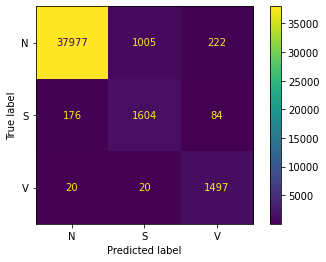

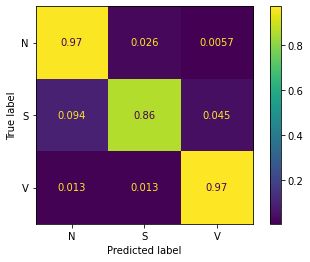

In [41]:
#Plotting the confusion matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

ConfusionMatrixDisplay.from_predictions(y, y_pred, labels = ['N', 'S', 'V'])
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', labels = ['N', 'S', 'V'])

In [42]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           N       0.99      0.97      0.98     39204
           S       0.61      0.86      0.71      1864
           V       0.83      0.97      0.90      1537

    accuracy                           0.96     42605
   macro avg       0.81      0.93      0.86     42605
weighted avg       0.97      0.96      0.97     42605



In [43]:
vgg.save('/content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/vgg model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AppliedAIinBiomedicine/final-assignment/vgg model/assets
